# Image Segmentation

## Importing Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import PIL

from pathlib import Path
from sklearn.model_selection import *
from tensorflow import keras
from tensorflow.keras.layers import *

print(tf.__version__)

2.4.1


## Loading and Creating Dataset

In [2]:
data_dir = "C:\\Users\\10699\.keras\datasets\ADE20K_2016_07_26\ADE20K_2016_07_26\images"
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'validation')

In [3]:
train_path = Path(train_dir)
val_path = Path(val_dir)
train_size = len(list(train_path.glob("**/*.jpg")))
val_size = len(list(val_path.glob("**/*.jpg")))
print('Number of Training Images: ', train_size)
print('Number of Validation Images: ', val_size)

Number of Training Images:  20210
Number of Validation Images:  2000


In [4]:
N = 0
for f in os.listdir(train_path):
    sub_path = os.path.join(train_path, f)
    for subs in os.listdir(sub_path):
        if os.path.isdir(os.path.join(sub_path, subs)):
            N += 1
print(N)

906


In [5]:
def display(path, idx = 0):
    img_list = list(path.glob("**/*.jpg"))
    mask_list = list(path.glob("**/*_seg.png"))
    img = PIL.Image.open(str(img_list[idx]))
    mask = PIL.Image.open(str(mask_list[idx]))
    img_cat = str(img_list[idx]).split("\\")[-2]
    
    plt.figure(figsize = (10,10))
    plt.subplot(1,2,1)
    plt.title(img_cat + ' Image (ID: ' + str(idx) +')')
    plt.imshow(img)
    
    plt.subplot(1,2,2)
    plt.title(img_cat + " Mask (ID: " + str(idx) + ')')
    plt.imshow(mask)

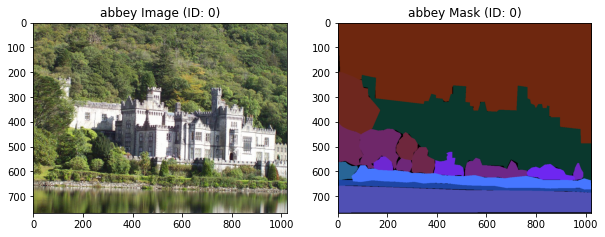

In [6]:
display(train_path)

In [7]:
SEED = 42

train_ds = tf.data.Dataset.list_files(train_dir + "/**/*.jpg", seed = SEED)
val_ds = tf.data.Dataset.list_files(val_dir + "/**/*.jpg", seed = SEED)

In [8]:
def image_decoding(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    
    mask_path = tf.strings.regex_replace(img_path, ".jpg", "_seg.png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image': img, 'mask': mask}

In [9]:
train_ds = train_ds.map(image_decoding)
val_ds = val_ds.map(image_decoding)

## Data Preprocessing

In [10]:
BATCH_SIZE = 4
BUFFER_SIZE = 1000
WIDTH= 128
HEIGHT = 128

In [11]:
@tf.function
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (WIDTH, HEIGHT))
    input_mask = tf.image.resize(datapoint['mask'], (WIDTH, HEIGHT))
    
    return (input_image, input_mask)

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(load_image, num_parallel_calls = AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size = BUFFER_SIZE, seed=SEED).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.repeat().batch(batch_size = BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

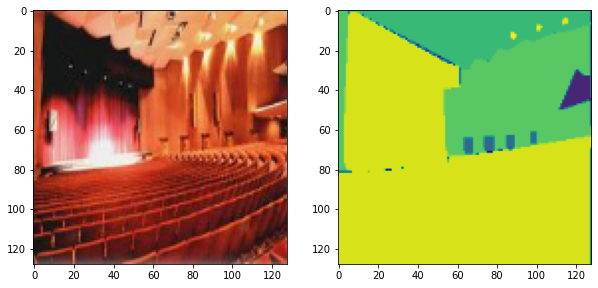

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(1):
        plt.subplot(1,2,1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.subplot(1,2,2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(labels[i]))

## Model Building

Use MobileNetv2 as the encoder of the UNet

In [ ]:
base_model = keras.applications.MobileNetV2(input_shape = [WIDTH, HEIGHT, 3], include_top = False)

In [ ]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
encoder = tf.keras.Model(inputs = base_model.input, outputs = layers)
encoder.trainable = False

In [14]:
initializer = 'he_normal'
dropout_rate = 0.5

In [15]:
# -- Encoder -- #
# Block encoder 1
inputs = Input(shape = (WIDTH, HEIGHT, 3))
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Dencoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N, 1, activation = 'softmax')(conv_dec_4)

In [16]:
model = tf.keras.Model(inputs = inputs, outputs = output)

In [ ]:
def downsample(filters, size, norm_type = 'BN', apply_norm = True): 
    initializer = tf.keras.initializers.HeNormal()

    encoder_block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                               kernel_initializer = initializer, use_bias=False)
    ])

    if apply_norm:
        if norm_type.lower() == 'BN':
            encoder_block.add(tf.keras.layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            encoder_block.add(InstanceNormalization())

    encoder_block.add(tf.keras.layers.LeakyReLU())

    return encoder_block

In [ ]:
def upsample(filters, size, norm_type='BN', apply_dropout=False):
    initializer = tf.keras.initializers.HeNormal()
    
    decoder_block = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                        kernel_initializer=initializer, use_bias=False)
    ])
    
    if norm_type.lower() == 'BN':
        decoder_block.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        decoder_block.add(InstanceNormalization())

    if apply_dropout:
        decoder_block.add(tf.keras.layers.Dropout(dropout_rate))

    decoder_block.add(tf.keras.layers.ReLU())

    return decoder_block

In [ ]:
def UNet(output_channels, norm_type = 'BN'):
    encoder = [
        downsample(64, 4, norm_type, apply_norm = False),  # (bs, 128, 128, 64)
        downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
        downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
        downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
        downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
        downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
        downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
        downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

    decoder = [
        upsample(512, 4, norm_type, apply_dropout = True),  # (bs, 2, 2, 1024)
        upsample(512, 4, norm_type, apply_dropout = True),  # (bs, 4, 4, 1024)
        upsample(512, 4, norm_type, apply_dropout = True),  # (bs, 8, 8, 1024)
        upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
        upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
        upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
        upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides = 2, padding = 'same', 
                                           kernel_initializer = initializer, activation = 'tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()
    
    inputs = tf.keras.layers.Input(shape=[WIDTH, HEIGHT, 3])
    x = inputs
    
    skips = []
    for down in encoder:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [ ]:
model = UNet(151)

In [17]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    return pred_mask
    
def show_predictions(dataset = None, num = 1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)[0]])
    else:
        one_img_batch = sample_image[0][tf.newaxis, ...]
        inference = model.predict(one_img_batch)
        pred_mask = create_mask(inference)
        display_sample([sample_image[0], sample_mask[0], pred_mask[0]])

In [19]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

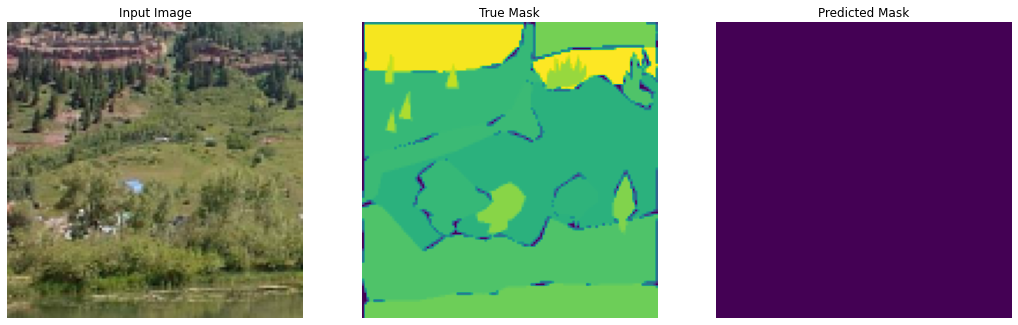

In [25]:
for image, mask in train_ds.take(1):
    sample_image, sample_mask = image, mask

show_predictions(train_ds)

In [21]:
EPOCHS = 1

STEPS_PER_EPOCH = train_size // BATCH_SIZE
VALIDATION_STEPS = val_size // BATCH_SIZE

In [22]:
model_history = model.fit(train_ds, epochs = EPOCHS,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS,
                          validation_data = val_ds)

5052/5052 [==============================] - 3213s 631ms/step - loss: 5.9702 - accuracy: 0.0282 - val_loss: 4.8819 - val_accuracy: 0.0492


In [23]:
model.save_weights('trained_01.hdf5')